# Setup

In [5]:
!pip show transformers
!pip show accelerate

Name: transformers
Version: 4.37.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
Name: accelerate
Version: 0.26.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [2]:
!pip install transformers[torch] -U
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 30.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [6]:
!pip install transformers
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 31.7 MB/s eta 0:00:00


# Imports and Visualize Data

<ipython-input-8-b81426cded5b>:8: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26,27,28,29,39) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
<ipython-input-8-b81426cded5b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
<ipython-input-8-b81426cded5b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

                                                                                                                                            comment_text  \
240493                                             0.0                                                               so sad they're no longer doing it."   
240528                                             0.0                                                            send them to TES in TN or PAWS in CA."   
240727                                             0.3                                                  and that was because of people moving here be...   
241185                                             0.0                                                  either in person or by proxy. That just doesn...   
241748                                             0.0                                                  and their god supports them with the action t...   
242588                                             0.0          

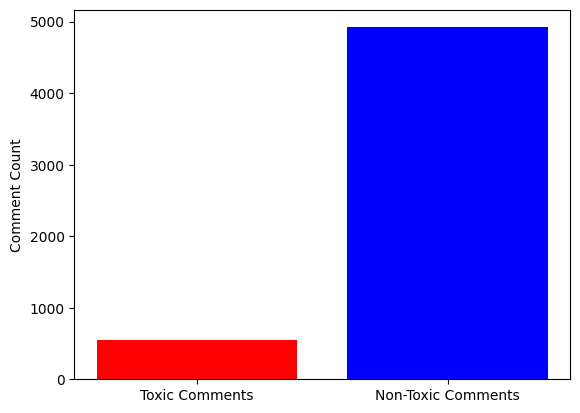

In [8]:
# Imports
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV
toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_train_df = toxicity_train_df.dropna()

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

# Check if any category is above the 0.5 threshold
toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.5 threshold
toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.5).any(axis=1).astype(float)

# Convert boolean values to 1.0 for True and 0.0 for False
toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
print(toxicity_train_df.head(20))

# toxicity_train_df['id'] = range(len(toxicity_df))

# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['toxic'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Pre-Processing

In [9]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it

model_name = "roberta-base"

# Train Data - 52662 rows after pre-processing (done above)
X_train = toxicity_train_df[['comment_text']]
y_train = toxicity_train_df[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']]
# toxicity_train_df.info()

# Test Data - 7287 rows after pre-processing
toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_test_df = toxicity_test_df.dropna()
X_test = toxicity_test_df[['comment_text']]
y_test = toxicity_test_df[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']]
# toxicity_test_df.info()

train_texts = X_train['comment_text'].tolist()
train_labels = y_train
test_texts = X_test['comment_text'].tolist()
test_labels = y_test

print("train_texts:")
print(train_texts)
print("train_labels:")
print(train_labels)
print("test_texts")
print(test_texts)
print("test_labels:")
print(test_labels)

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)

<ipython-input-9-56bddf65f896>:22: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)


train_texts:
[' so sad they\'re no longer doing it."', ' send them to TES in TN or PAWS in CA."', ' and that was because of people moving here because of that stupid show."', ' either in person or by proxy. That just doesn\'t set right for me."', ' and their god supports them with the action they\'ve taken.  Intelligent or intellectually limited all these militia\'s attract a very dangerous group of people with crackpot ideas.  Please don\'t feel sorry for them they have chosen the path they have taken that could limit your rights and mine."', ' gun violence correlates to number of guns on a per capita basis. It\'s very much like noting – using your analogy – that the number of swimming pool injuries and deaths in a location will correlate with the number of swimming pools."', '"" but he was old enough to know that killing other people is something you can never take back. The purpose of him being in jail is that we like to think of ourselves as a civilized society that would not put h

# Dataset

In [10]:
# class toxicDataset(Dataset):
#     def __init__(self, encodings, labels):
#       self.encodings = encodings
#       self.labels = labels

#     def __getitem__(self, idx):
#       # return item
#       item = {key: torch.tensor([val[idx] for val in self.encodings.values()]) for key in self.encodings.keys()}
#       item['labels'] = torch.tensor(self.labels[idx])
#       return item

#     def __len__(self):
#       return len(self.labels)

class toxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        try:
            print("Encodings at index", idx, ":", self.encodings)
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item
        except Exception as e:
            print(f"Error at index {idx}: {e}")
            raise

    def __len__(self):
        return len(self.labels)


from transformers import RobertaTokenizer, RobertaModel
# Unfortunately no such thing exists :(
# from transformers import RobertaModelForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = toxicDataset(train_encodings, train_labels)
val_dataset = toxicDataset(val_encodings, val_labels)
test_dataset = toxicDataset(test_encodings, test_labels)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

# Tokenizer + Encodings + Training

In [12]:
from transformers import RobertaTokenizer, RobertaModel

# Unfortunately no such thing exists :(
# from transformers import RobertaModelForSequenceClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = toxicDataset(train_encodings, train_labels)
val_dataset = toxicDataset(val_encodings, val_labels)
test_dataset = toxicDataset(test_encodings, test_labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

model = AutoModelForSequenceClassification.from_pretrained('roberta-base')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyError: 2608

# Try Native PyTorch Training Loop instead of Hugging Face Trainer

In [15]:
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForSequenceClassification.from_pretrained('roberta-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16)
optim = AdamW(model.parameters(), lr=5e-5)

print("Dataset length:", len(train_loader.dataset))
print(train_loader.dataset.encodings.keys())
# Errors on the line below
print("Keys of the first item:", list(train_loader.dataset[0].keys()))


num_train_epochs = 2
for epoch in range(num_train_epochs):
  for batch in train_loader:
    optim.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    loss = outputs[0]
    loss.backward()
    optim.step()

model.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dataset length: 4380
dict_keys(['input_ids', 'attention_mask'])
Encodings at index 0 : 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyError: 0